## Orthogonal Random Forest and Causal Forest

Causal Forests and Generalized Random Forests are a flexible method for estimating treatment effect heterogeneity with Random Forests. Orthogonal Random Forest (ORF) combines orthogonalization, a technique that effectively removes the confounding effect in two-stage estimation, with generalized random forests. Due to the orthogonalization aspect of this method, the ORF performs especially well in the presence of high-dimensional confounders.

In [1]:
from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso

import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LogisticRegression
import matplotlib.pyplot as plt

### 1. Continuous Treatment Synthetic Data

#### 1.1 Data Generating Process

we use the data generating process (DGP) from here. The DGP is described by the following equations

$$
\begin{align}
T =& \langle W, \beta\rangle + \eta, & \;\eta \sim \text{Uniform}(-1, 1)\\
Y =& T\cdot \theta(X) + \langle W, \gamma\rangle + \epsilon, &\; \epsilon \sim \text{Uniform}(-1, 1)\\
W \sim& \text{Normal}(0,\, I_{n_w})\\
X \sim& \text{Uniform}(0,1)^{n_x}
\end{align}
$$

where $W$ is a matrix of high-dimensional confounders and $\beta, \gamma$ have high sparsity.

for this Data Generating Process,

$$\theta(x) = \exp(2 \cdot x_1)$$

In [2]:
# Treatment effect function
def exp_te(x) :
    return np.exp(2 * x[0])

In [9]:
# DGP constants
np.random.seed(42) # set random seed

n = 1000
n_w = 30
support_size = 5
n_x = 1

In [5]:
# outcome support
support_Y = np.random.choice(
    range(n_w), 
    size = support_size, 
    replace = False
)
coefs_Y = np.random.uniform(
    0, 1, size = support_size
)

def epsilon_sample(n) :
    return np.random.uniform(-1, 1, size = n) # mean -1, std 1, num of obs is n

In [6]:
# Treatment support
support_T = support_Y
coefs_T = np.random.uniform(
    0, 1, size = support_size # mean 0, std 1, num of obs equal support size
)
def eta_sample(n) :
    return np.random.uniform(-1, 1, size = n)

In [10]:
# Generate controls, covariates, treatments and outcomes

W = np.random.normal(0, 1, size=(n, n_w))
X = np.random.uniform(0, 1, size=(n, n_x))

In [12]:
# Heterogeneous treatment effects
TE = np.array(
    [exp_te(x_i) for x_i in X]
)
T = np.dot(W[:, support_T], coefs_T) + eta_sample(n)
Y = TE * T + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)

In [13]:
# Orthogonal Random Forest parameters and test data
subsample_ratio = 0.3
lambda_reg = np.sqrt(np.log(n_w) / (10 * subsample_ratio * n))
X_test = np.array(
    list(product(np.arange(0, 1, 0.01), repeat=n_x))
)

#### 1.2 Train Estimator

**Note** : The models in the final stage of the estimation (`model_T_final`, `model_Y_final`) need to support sample weighting.

If the models of choice do not support sample weights (e.g. `sklearn.linear_model.LassoCV`), the `econml` packages provides a convenient wrapper for these models `WeightedModelWrapper` in order to allow sample weights.

In [23]:
dml_forest = DMLOrthoForest(
    n_trees = 1000,
    min_leaf_size = 5,
    max_depth = 50,
    subsample_ratio = subsample_ratio,
    model_T = Lasso(alpha = lambda_reg, max_iter = 10000),
    model_Y = Lasso(alpha = lambda_reg, max_iter = 10000),
    model_T_final = WeightedLasso(alpha = lambda_reg, max_iter = 10000),
    model_Y_final = WeightedLasso(alpha = lambda_reg, max_iter = 10000),
    global_residualization = False,
    random_state = 42
)

To use the built-in confidence intervals constructed via Bootstrap of Little Bags, we can specify `inference="blb"` at `fit` time or leave the default `inference='auto'` which will automatically use the Bootstrap of Little Bags.

In [24]:
dml_forest.fit(
    Y = Y, 
    T = T,
    X = X,
    W = W,
    inference = 'blb',
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 843 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.6s finished


In [25]:
# calculate treatment effects
treatment_effects = dml_forest.effect(
    X_test
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.9s finished


In [26]:
# calculate default (95%) confidence intervals for the test data
te_lower, te_upper = dml_forest.effect_interval(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished


In [27]:
res = dml_forest.effect_inference(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished


In [28]:
res.summary_frame().head()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
0,1.188,0.183,6.491,0.0,0.829,1.547
1,1.198,0.178,6.728,0.0,0.849,1.546
2,1.207,0.173,6.965,0.0,0.867,1.547
3,1.216,0.169,7.198,0.0,0.885,1.548
4,1.226,0.165,7.425,0.0,0.902,1.550


In [30]:
print(res.population_summary())

               Uncertainty of Mean Point Estimate               
mean_point stderr_mean zstat  pvalue ci_mean_lower ci_mean_upper
----------------------------------------------------------------
     3.176       0.286 11.122    0.0         2.617         3.736
      Distribution of Point Estimate     
std_point pct_point_lower pct_point_upper
-----------------------------------------
    1.728           1.212           6.546
     Total Variance of Point Estimate     
stderr_point ci_point_lower ci_point_upper
------------------------------------------
       1.752          1.102          6.804
------------------------------------------

Note: The stderr_mean is a conservative upper bound.


Similarly we can estimate effects and get confidence intervals and inference results using a `CausalForest`.

In [32]:
causal_forest = CausalForestDML(
    model_t = Lasso(alpha = lambda_reg, max_iter = 10000),
    model_y = Lasso(alpha = lambda_reg, max_iter = 10000),
    n_estimators = 4000,
    min_samples_leaf = 5,
    max_depth = 50,
    verbose = 0,
    random_state = 42
)

In [33]:
causal_forest.tune(
    Y = Y, 
    T = T, 
    X = X, 
    W = W
)
causal_forest.fit(
    Y = Y, 
    T = T, 
    X = X, 
    W = W
)

In [34]:
treatment_effects2 = causal_forest.effect(X_test)
te_lower2, te_upper2 = causal_forest.effect_interval(
    X_test, 
    alpha = 0.01
)

#### 1.3 Performance Visulaization

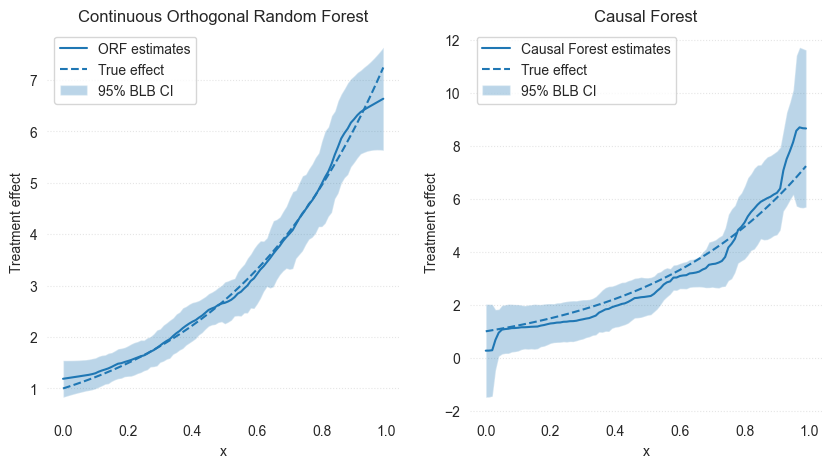

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))

ax1.set_title('Continuous Orthogonal Random Forest')
ax1.plot(
    X_test, treatment_effects, label = 'ORF estimates'
)
expected_te = np.array([exp_te(x_i) for x_i in X_test])
ax1.plot(
    X_test[:, 0], expected_te, ls = '--', color = 'tab:blue', label='True effect'
)
ax1.fill_between(
    X_test[:, 0], 
    te_lower, te_upper,
    label = "95% BLB CI", 
    alpha = 0.3
)
ax1.set_ylabel('Treatment effect')
ax1.set_xlabel('x')
for spine in ax1.spines.values():
    spine.set_visible(False)
ax1.grid(False)
ax1.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax1.legend()

ax2.set_title('Causal Forest')
ax2.plot(
    X_test, treatment_effects2, label = 'Causal Forest estimates'
)
expected_te = np.array([exp_te(x_i) for x_i in X_test])
ax2.plot(
    X_test[:, 0], expected_te, ls = '--', color = 'tab:blue', label='True effect'
)
ax2.fill_between(
    X_test[:, 0], 
    te_lower2, te_upper2, 
    label="95% BLB CI",
    alpha=0.3
)
ax2.set_ylabel('Treatment effect')
ax2.set_xlabel('x')
for spine in ax2.spines.values():
    spine.set_visible(False)
ax2.grid(False)
ax2.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax2.legend()
plt.show()

### 2. Using with Binary Treatment Synthetic Data

#### 2.1 Data Generating Process

We use the following DGP:

$$\begin{align}
T \sim & \text{Bernoulli}\left(f(W)\right), &\; f(W)=\sigma(\langle W, \beta\rangle + \eta), \;\eta \sim \text{Uniform}(-1, 1)\\
Y = & T\cdot \theta(X) + \langle W, \gamma\rangle + \epsilon, & \; \epsilon \sim \text{Uniform}(-1, 1)\\
W \sim & \text{Normal}(0,\, I_{n_w}) & \\
X \sim & \text{Uniform}(0,\, 1)^{n_x}
\end{align}$$

where $W$ is a matrix of high-dimensional confounders, $\beta, \gamma$ have high sparsity and $\sigma$ is the sigmoid function.

For this DGP, 
\begin{align}
\theta(x) = \exp( 2\cdot x_1 ).
\end{align}

In [43]:
# Data Generating Process constants
np.random.seed(42)
n = 1000
n_w = 30
support_size = 5
n_x = 1

In [44]:
# OUtcome support
support_Y = np.random.choice(
    range(n_w), 
    size = support_size, 
    replace = False
)
coefs_Y = np.random.uniform(
    0, 1, 
    size = support_size
)
def epsilon_sample(n):
    return np.random.uniform(-1, 1, size=n)

In [45]:
# Treatment support
support_T = support_Y
coefs_T = np.random.uniform(
    0, 1, 
    size = support_size
)
def eta_sample(n):
    return np.random.uniform(-1, 1, size = n)

In [46]:
# Generate controls, covariates, treatments and outcomes
W = np.random.normal(0, 1, size=(n, n_w))
X = np.random.uniform(0, 1, size=(n, n_x))

In [47]:
# Heterogeneous treatment effects
TE = np.array([exp_te(x_i) for x_i in X])

In [48]:
# Define treatment
log_odds = np.dot(W[:, support_T], coefs_T) + eta_sample(n)
T_sigmoid = 1/(1 + np.exp(-log_odds))
T = np.array([np.random.binomial(1, p) for p in T_sigmoid])

In [49]:
# Define the outcome
Y = TE * T + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)

In [50]:
# ORF parameters and test data
subsample_ratio = 0.4
X_test = np.array(
    list(product(np.arange(0, 1, 0.01), repeat = n_x))
)

#### 2.2 Train Estimator

In [51]:
ortho_forest_bin = DROrthoForest(
    n_trees = 200,
    min_leaf_size = 10,
    max_depth = 30,
    subsample_ratio = subsample_ratio,
    propensity_model = LogisticRegression(
        C = 1/(X.shape[0] * lambda_reg), 
        penalty = 'l1',
        solver = 'saga'
    ),
    model_Y = Lasso(alpha = lambda_reg, max_iter = 10000),
    propensity_model_final = LogisticRegression(
        C = 1 / (X.shape[0] * lambda_reg), 
        penalty = 'l1',
        solver = 'saga'
    ),
    model_Y_final = WeightedLasso(alpha = lambda_reg, max_iter = 10000),
)

In [52]:
ortho_forest_bin.fit(
    Y = Y, T = T, X = X, W = W
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.6s finished


In [53]:
# Calculate treatment effects for the default treatment points T0=0 and T1=1
treatment_effects = ortho_forest_bin.effect(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.4s finished


In [54]:
# Calculate default (95%) confidence intervals for the default treatment points T0=0 and T1=1
te_lower, te_upper = ortho_forest_bin.effect_interval(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished


In [55]:
causal_forest_bin = CausalForestDML(
    model_y = Lasso(
        alpha = lambda_reg, 
        max_iter = 10000
    ),
    model_t = LogisticRegression(
        C = 1 / (X.shape[0] * lambda_reg)
    ),
    n_estimators = 200,
    min_samples_leaf = 5,
    max_depth = 50,
    max_samples = subsample_ratio/2,
    discrete_treatment = True,
    random_state = 42
)

In [57]:
causal_forest_bin.fit(
    Y = Y, T = T, X = X, W = W, cache_values = True
)

In [58]:
treatment_effects2 = causal_forest_bin.effect(X_test)
te_lower2, te_upper2 = causal_forest_bin.effect_interval(X_test)

In [60]:
causal_forest_bin.summary()

Population summary of CATE predictions on Training Data


<class 'econml.utilities.Summary'>
"""
               Uncertainty of Mean Point Estimate               
================================================================
mean_point stderr_mean zstat  pvalue ci_mean_lower ci_mean_upper
----------------------------------------------------------------
     3.161       0.146 21.689    0.0         2.876         3.447
      Distribution of Point Estimate     
=========================================
std_point pct_point_lower pct_point_upper
-----------------------------------------
    1.743           1.134           6.693
     Total Variance of Point Estimate     
==========================================
stderr_point ci_point_lower ci_point_upper
------------------------------------------
       1.749          1.042          6.715
        Doubly Robust ATE on Training Data Results       
=========================================================
    point_estimate stderr zstat  pvalue ci_lower ci_upper
---------------------------------------------------------
ATE          3.184  0.074 43.156    0.0     3.04    3.329
     Doubly Robust ATT(T=0) on Training Data Results     
=========================================================
    point_estimate stderr zstat  pvalue ci_lower ci_upper
---------------------------------------------------------
ATT          3.195  0.097 32.916    0.0    3.004    3.385
     Doubly Robust ATT(T=1) on Training Data Results     
=========================================================
    point_estimate stderr zstat  pvalue ci_lower ci_upper
---------------------------------------------------------
ATT          3.175   0.11 28.933    0.0     2.96     3.39
---------------------------------------------------------

Note: The stderr_mean is a conservative upper bound.
"""

#### 2.3 Performance Visualization

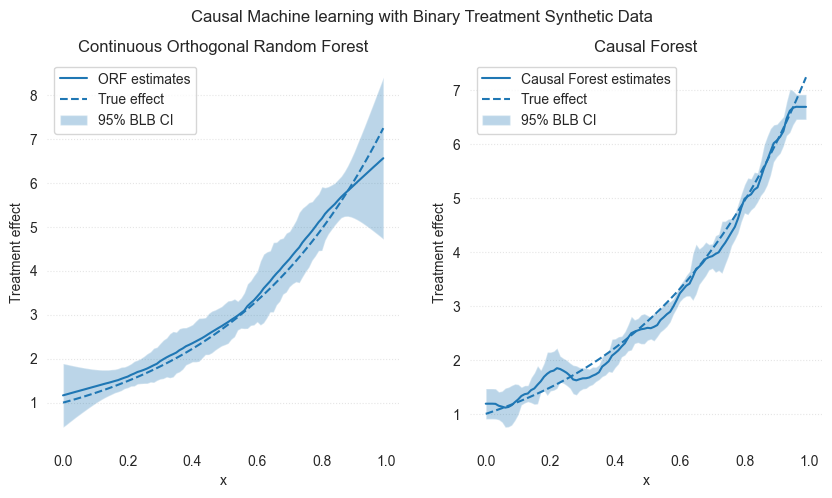

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))

ax1.set_title('Continuous Orthogonal Random Forest')
ax1.plot(
    X_test, treatment_effects, label = 'ORF estimates'
)
expected_te = np.array([exp_te(x_i) for x_i in X_test])
ax1.plot(
    X_test[:, 0], expected_te, ls = '--', color = 'tab:blue', label='True effect'
)
ax1.fill_between(
    X_test[:, 0], 
    te_lower, te_upper,
    label = "95% BLB CI", 
    alpha = 0.3
)
ax1.set_ylabel('Treatment effect')
ax1.set_xlabel('x')
for spine in ax1.spines.values():
    spine.set_visible(False)
ax1.grid(False)
ax1.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax1.legend()

ax2.set_title('Causal Forest')
ax2.plot(
    X_test, treatment_effects2, label = 'Causal Forest estimates'
)
expected_te = np.array([exp_te(x_i) for x_i in X_test])
ax2.plot(
    X_test[:, 0], expected_te, ls = '--', color = 'tab:blue', label='True effect'
)
ax2.fill_between(
    X_test[:, 0], 
    te_lower2, te_upper2, 
    label="95% BLB CI",
    alpha=0.3
)
ax2.set_ylabel('Treatment effect')
ax2.set_xlabel('x')
for spine in ax2.spines.values():
    spine.set_visible(False)
ax2.grid(False)
ax2.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax2.legend()

plt.suptitle('Causal Machine learning with Binary Treatment Synthetic Data')
plt.show()

### 3. Multiple Treatment Synthetic Data

#### 3.1 Data Generating Process

We use the following DGP:

$$\begin{align}
Y = & \sum_{t=1}^{n_{\text{treatments}}} 1\{T=t\}\cdot \theta_{T}(X) + \langle W, \gamma\rangle + \epsilon, \; \epsilon \sim \text{Unif}(-1, 1), \\
\text{Pr}[T=t \mid W] \propto & \exp\{\langle W, \beta_t \rangle\}, \;\;\;\; \forall t\in \{0, 1, \ldots, n_{\text{treatments}}\} 
\end{align}$$

where $W$ is a matrix of high-dimensional confounders, $\beta_t, \gamma$ are sparse.

For this particular example DGP we used $n_{\text{treatments}}=3$ and 
$$\begin{align}
\theta_1(x) = & \exp( 2 x_1 ),\\
\theta_2(x) = &  3 \cdot \sigma(100\cdot (x_1 - .5)),\\
\theta_3(x) = & -2 \cdot \sigma(100\cdot (x_1 - .25)),
\end{align}$$
where $\sigma$ is the sigmoid function.

In [72]:
def get_test_train_data(n, n_w, support_size, n_x, te_func, n_treatments):
    
    # Outcome support
    support_Y = np.random.choice(range(n_w), size=support_size, replace=False)
    coefs_Y = np.random.uniform(0, 1, size=support_size)
    def epsilon_sample(n):
        return np.random.uniform(-1, 1, size=n)
    
    # Treatment support
    support_T = support_Y
    coefs_T = np.random.uniform(0, 1, size=(support_size, n_treatments))
    
    def eta_sample(n):
        return np.random.uniform(-1, 1, size=n)
    
    # Generate controls, covariates, treatments and outcomes
    W = np.random.normal(0, 1, size=(n, n_w))
    X = np.random.uniform(0, 1, size=(n, n_x))
    
    # Heterogeneous treatment effects
    TE = np.array([te_func(x_i, n_treatments) for x_i in X])
    log_odds = np.dot(W[:, support_T], coefs_T)
    T_sigmoid = np.exp(log_odds)
    T_sigmoid = T_sigmoid/np.sum(T_sigmoid, axis=1, keepdims=True)
    T = np.array([np.random.choice(n_treatments, p=p) for p in T_sigmoid])
    TE = np.concatenate((np.zeros((n,1)), TE), axis=1)
    Y = TE[np.arange(n), T] + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)
    X_test = np.array(list(product(np.arange(0, 1, 0.01), repeat=n_x)))

    return (Y, T, X, W), (X_test, np.array([te_func(x, n_treatments) for x in X_test]))

In [73]:
import scipy.special
def te_func(x, n_treatments):
    return [np.exp(2*x[0]), 3*scipy.special.expit(100*(x[0] - .5)) - 1, -2*scipy.special.expit(100*(x[0] - .25))]

np.random.seed(42)
(Y, T, X, W), (X_test, te_test) = get_test_train_data(2000, 3, 3, 1, te_func, 4)

#### 3.2 Train Estimator

In [111]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings('ignore', category=ConvergenceWarning)

ortho_forest_multi = DROrthoForest(
    n_trees = 500,
    model_Y = WeightedLasso(
        alpha = lambda_reg,
        max_iter = 1000
    ),
    min_leaf_size = 30,
    max_depth = 30
)

In [112]:
ortho_forest_multi.fit(
    Y = Y, T = T, X = X, W = W
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which

In [113]:
# Calculate marginal treatment effects
treatment_effects = ortho_forest_multi.const_marginal_effect(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.9s finished


In [114]:
# Calculate default (95%) marginal confidence intervals for the test data
te_lower, te_upper = ortho_forest_multi.const_marginal_effect_interval(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished


In [115]:
res = ortho_forest_multi.const_marginal_effect_inference(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished


In [116]:
res.summary_frame()

point_estimate  stderr   zstat  pvalue  ci_lower  ci_upper
X  T                                                               
0  T0_1           1.103   0.242   4.556   0.000     0.629     1.578
   T0_2          -0.870   0.138  -6.315   0.000    -1.140    -0.600
   T0_3           0.221   0.328   0.673   0.501    -0.422     0.863
1  T0_1           1.120   0.227   4.944   0.000     0.676     1.564
   T0_2          -0.875   0.137  -6.390   0.000    -1.143    -0.607
...                 ...     ...     ...     ...       ...       ...
98 T0_2           1.958   0.137  14.307   0.000     1.690     2.226
   T0_3          -2.043   0.158 -12.927   0.000    -2.352    -1.733
99 T0_1           6.291   0.746   8.437   0.000     4.829     7.752
   T0_2           1.954   0.137  14.247   0.000     1.685     2.223
   T0_3          -2.046   0.159 -12.891   0.000    -2.357    -1.735

[300 rows x 6 columns]

In [117]:
causal_forest_multi = CausalForestDML(
    model_y = Lasso(alpha = lambda_reg, max_iter = 1000),
    model_t = LogisticRegression(C = 1/(X.shape[0] * lambda_reg)),
    n_estimators = 4000,
    min_samples_leaf = 5,
    max_depth = 50,
    max_samples = subsample_ratio/2,
    discrete_treatment = True,
    random_state = 42
)
causal_forest_multi.fit(Y = Y, T = T, X = X, W = W)

In [118]:
treatment_effects2 = causal_forest_multi.const_marginal_effect(X_test)
te_lower2, te_upper2 = causal_forest_multi.const_marginal_effect_interval(X_test, alpha=0.01)

#### 3.3 Performance Visualization

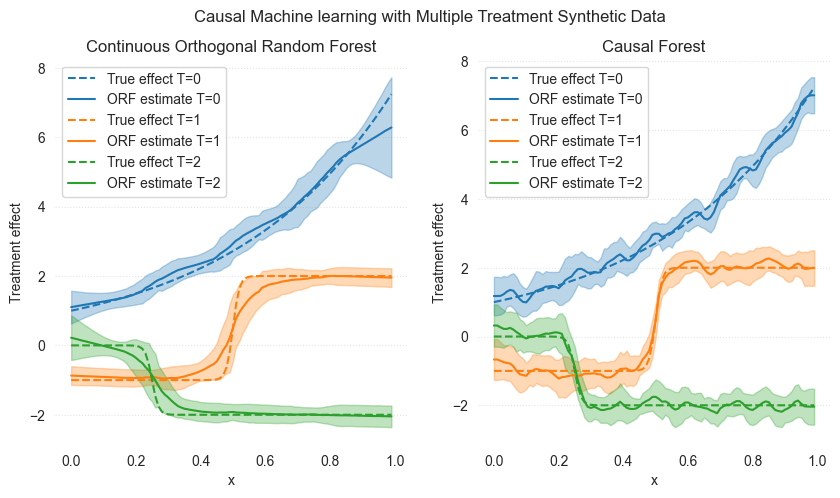

In [122]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))

ax1.set_title('Continuous Orthogonal Random Forest')
y = treatment_effects
colors = ['tab:blue', 'tab:orange', 'tab:green']
for it in range(y.shape[1]):
    ax1.plot(X_test[:, 0], te_test[:, it], '--', label='True effect T={}'.format(it), color=colors[it])
    ax1.fill_between(X_test[:, 0], te_lower[:, it], te_upper[:, it], alpha=0.3, color='C{}'.format(it))
    ax1.plot(X_test, y[:, it], label='ORF estimate T={}'.format(it), color='C{}'.format(it))
ax1.set_ylabel('Treatment effect')
ax1.set_xlabel('x')
for spine in ax1.spines.values():
    spine.set_visible(False)
ax1.grid(False)
ax1.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax1.legend()

ax2.set_title('Causal Forest')
y = treatment_effects2
for it in range(y.shape[1]):
    ax2.plot(X_test[:, 0], te_test[:, it], '--', label='True effect T={}'.format(it), color=colors[it])
    ax2.fill_between(X_test[:, 0], te_lower2[:, it], te_upper2[:, it], alpha=0.3, color='C{}'.format(it))
    ax2.plot(X_test, y[:, it], label='ORF estimate T={}'.format(it), color='C{}'.format(it))
ax2.set_ylabel('Treatment effect')
ax2.set_xlabel('x')
for spine in ax2.spines.values():
    spine.set_visible(False)
ax2.grid(False)
ax2.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax2.legend()

plt.suptitle('Causal Machine learning with Multiple Treatment Synthetic Data')
plt.show()

### 4. Example Usage with Real Continuous Treatment Observational Data

We applied our technique to Dominick’s dataset, a popular historical dataset of store-level orange juice prices and sales provided by University of Chicago Booth School of Business. 

The dataset is comprised of a large number of covariates $W$, but researchers might only be interested in learning the elasticity of demand as a function of a few variables $x$ such
as income or education. 

We applied the `DMLOrthoForest` to estimate orange juice price elasticity
as a function of income, and our results, unveil the natural phenomenon that lower income consumers are more price-sensitive.

#### 4.1. Data

In [123]:
# A few more imports
import os
import pandas as pd
import urllib.request
from sklearn.preprocessing import StandardScaler

In [124]:
# Import the data
file_name = "oj_large.csv"

if not os.path.isfile(file_name):
    print("Downloading file (this might take a few seconds)...")
    urllib.request.urlretrieve("https://msalicedatapublic.z5.web.core.windows.net/datasets/OrangeJuice/oj_large.csv",
                               file_name)
oj_data = pd.read_csv(file_name)
oj_data.head()

,store,brand,week,logmove,feat,price,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
0,2,tropicana,40,9.018695,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
1,2,tropicana,46,8.723231,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
2,2,tropicana,47,8.253228,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
3,2,tropicana,48,8.987197,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
4,2,tropicana,50,9.093357,0,3.87,0.232865,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927


In [125]:
# Prepare data
Y = oj_data['logmove'].values # target
T = np.log(oj_data["price"]).values # treatment effect
scaler = StandardScaler()

W1 = scaler.fit_transform(
    oj_data[[c for c in oj_data.columns if c not in ['price', 'logmove', 'brand', 'week', 'store']]].values
)
W2 = pd.get_dummies(oj_data[['brand']]).values

W = np.concatenate([W1, W2], axis=1)
X = oj_data[['INCOME']].values

#### 4.2 Train Estimator

In [126]:
# Define some parameters
n_trees = 1000
min_leaf_size = 50
max_depth = 20
subsample_ratio = 0.04

In [128]:
estimator = DMLOrthoForest(
    n_trees = n_trees,
    min_leaf_size = min_leaf_size,
    max_depth = max_depth,
    subsample_ratio = subsample_ratio,
    model_T = Lasso(alpha = 0.1),
    model_Y = Lasso(alpha = 0.1),
    model_T_final = WeightedLassoCVWrapper(cv = 3),
    model_Y_final = WeightedLassoCVWrapper(cv = 3)
)

In [129]:
estimator.fit(Y = Y, T = T, W = W, X = X)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   12.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.8s finished


In [130]:
min_income = 10.0
max_income = 11.1
delta = (max_income - min_income) / 100
X_test = np.arange(min_income, max_income + delta - 0.001, delta).reshape(-1, 1)

In [131]:
# Calculate marginal treatment effects
treatment_effects = estimator.const_marginal_effect(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   29.9s finished


In [132]:
# Calculate default (95%) marginal confidence intervals for the test data
te_upper, te_lower = estimator.const_marginal_effect_interval(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   12.7s finished


In [133]:
estimator2 = CausalForestDML(
    model_y = WeightedLassoCVWrapper(cv = 3),
    model_t = WeightedLassoCVWrapper(cv = 3),
    n_estimators = n_trees,
    min_samples_leaf = min_leaf_size,
    max_depth = max_depth,
    max_samples = subsample_ratio/2,
    random_state = 42
)

In [134]:
estimator2.fit(Y = Y, T = T, X = X, W = W)

In [135]:
treatment_effects2 = estimator2.effect(X_test)
te_lower2, te_upper2 = estimator2.effect_interval(X_test)

#### 4.3 Performance Visulization

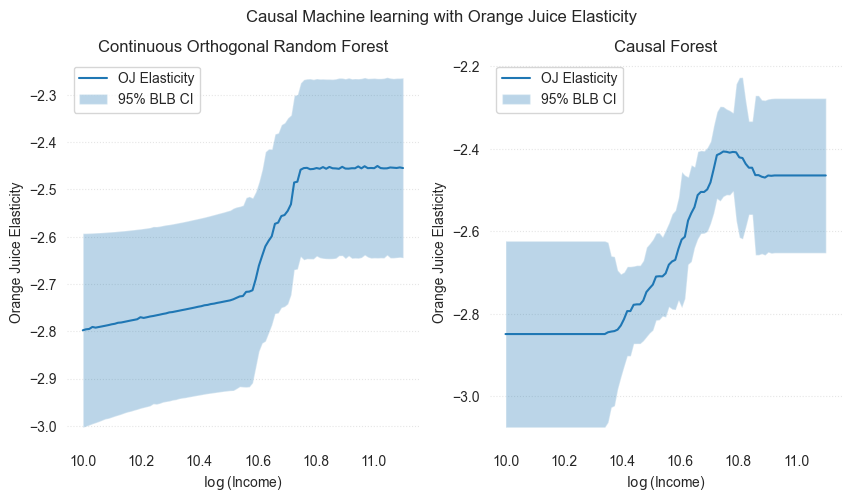

In [138]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))

ax1.set_title('Continuous Orthogonal Random Forest')
ax1.plot(
    X_test.flatten(), treatment_effects, label="OJ Elasticity"
)
ax1.fill_between(
    X_test.flatten(), 
    te_lower, te_upper,
    label = "95% BLB CI", 
    alpha = 0.3
)
ax1.set_ylabel('Orange Juice Elasticity')
ax1.set_xlabel(r'$\log$(Income)')
for spine in ax1.spines.values():
    spine.set_visible(False)
ax1.grid(False)
ax1.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax1.legend()

ax2.set_title('Causal Forest')
ax2.plot(
    X_test.flatten(), treatment_effects2, label = "OJ Elasticity"
)
expected_te = np.array([exp_te(x_i) for x_i in X_test])
ax2.fill_between(
    X_test.flatten(), 
    te_lower2, te_upper2, 
    label="95% BLB CI",
    alpha=0.3
)
ax2.set_ylabel('Orange Juice Elasticity')
ax2.set_xlabel(r'$\log$(Income)')
for spine in ax2.spines.values():
    spine.set_visible(False)
ax2.grid(False)
ax2.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax2.legend()

plt.suptitle('Causal Machine learning with Orange Juice Elasticity')
plt.show()